# Q3 Random Forests for classification

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import time
import hashlib
# import a file

from collections import defaultdict

In [3]:
# Using SHA-256 to generate unique seed
username = "m.samartha"
seed = int( hashlib.sha256(username.encode()).hexdigest(),16) % (2**32)
print(seed)
np.random.seed(seed)

def add_username(username = "m.samartha") -> None:
    plt.text(0.95, 0.95, username, ha="right", va="top", transform=plt.gca().transAxes, fontsize=10, color="gray", alpha=0.7)

def add_username_fig(username = "m.samartha", fig=None) -> None:
    if fig is None:
        fig = plt.gcf()
    fig.text(
        0.97, 0.97, "m.samartha",
        ha='right', va='top',
        fontsize=10, color='gray', alpha=0.7
    )

2669878649


In [4]:
import sklearn.tree
import sklearn.linear_model
import sklearn.metrics
import sklearn.ensemble

In [ ]:
def pretty_print_sklearn_tree(tree_clf, feature_names):
    ''' Print out a nice summary of the provided tree.

    Args
    ----
    tree_clf : instance of sklearn.tree.DecisionTreeClassifier
    feature_names : list of strings
        Provides a printable 'name' for each feature the model was trained with.

    Returns
    -------
    Nothing. Results printed to stdout.
    
    Notes
    -----
    Based on an sklearn tutorial. Here's a brief summary of how it works:

    # After training, any DecisionTreeClassifier an attribute called tree_ 
    # which stores the tree structure and allows access to key attributes.
    # The binary tree tree_ is represented as a number of parallel arrays.
    # The i-th element of each array holds information about the node `i`.
    # Node 0 is the tree's root.
    # Notes:
    # - Some of the arrays only apply to either leaves or split nodes, resp.
    # - In this case the values of nodes of the other type are arbitrary!
    #
    # Among those arrays, we have:
    #   - left_child, id of the left child of the node
    #   - right_child, id of the right child of the node
    #   - feature, feature used for splitting the node
    #   - threshold, threshold value at the node
    #   - value, counts of each class for train examples reaching this node

    By manipulating these arrays, we can parse the tree structure.
    '''

    n_nodes = tree_clf.tree_.node_count
    children_left = tree_clf.tree_.children_left
    children_right = tree_clf.tree_.children_right
    feature = tree_clf.tree_.feature
    threshold = tree_clf.tree_.threshold

    # The tree structure can be traversed to compute various properties
    # such as:
    # * the depth of each node 
    # * whether or not it is a leaf.

    node_depth_N = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaf_N = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth_N[node_id] = parent_depth + 1

        if (children_left[node_id] != children_right[node_id]):
            # Internal decision node
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            # Leaf node
            is_leaf_N[node_id] = True

    print("The binary tree structure has %s nodes." % n_nodes)
    depths_U, counts_U = np.unique(node_depth_N, return_counts=True)
    for uu in range(depths_U.size):
        is_at_cur_depth_N = depths_U[uu] == node_depth_N
        is_leaf_at_cur_depth_N = np.logical_and(
            is_leaf_N,
            is_at_cur_depth_N,
            )
        print("- depth %3d has %4d nodes, of which %4d are leaves" % (
            depths_U[uu], counts_U[uu], np.sum(is_leaf_at_cur_depth_N)))

    print("The decision tree:  (Note: Y = 'yes' to above question; N = 'no')")
    n_seen_by_depth = defaultdict(int)

    for i in range(n_nodes):
        cur_depth = node_depth_N[i]
        count_at_cur_depth = n_seen_by_depth[cur_depth]

        # Every other printout at same depth should alternate Y and N labels
        if node_depth_N[i] == 0:
            decision_str = '' # base case
        elif count_at_cur_depth % 2 == 0:
            decision_str = 'Y '
        else:
            decision_str = 'N '

        if is_leaf_N[i]:
            n_class0 = tree_clf.tree_.value[i,0,0]
            n_class1 = tree_clf.tree_.value[i,0,1]
            proba1 = n_class1 / (n_class1 + n_class0)
            print("%s%sLeaf: p(y=1 | this leaf) = %.3f (%d total training examples)" % (
                node_depth_N[i] * "  ", decision_str, proba1, n_class0 + n_class1))

        else:
            print("%s%sDecision: X['%s'] <= %.2f?" % (
                node_depth_N[i] * "  ",
                decision_str,
                feature_names[feature[i]],
                threshold[i],
                ))

        # Increment our counter so we get the alternating Y/N labels right
        n_seen_by_depth[cur_depth] += 1

    print()

In [6]:
# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

### Load all data from train/valid/test

In [ ]:
# https://iiithydstudents-my.sharepoint.com/:u:/g/personal/m_samartha_students_iiit_ac_in/IQCw2ZJM1_8ERb8NQhBdeeS1AVgWvwS-tA83DpTgiQMmH48?e=AEIA3a
# Use the above link to download the data and place it in the appropriate directory

data_dir = "./data_product_reviews"  # Update this path as needed

print(f"Loading data from: {data_dir}")

try:
    # --- Load Training Data ---
    x_train_path = os.path.join(data_dir, 'x_train.csv')
    
    # We use pandas to easily read the CSV, 
    # automatically skipping the header (row 0).
    # dtype=np.float64 ensures features are floats, as expected by the model
    df_x_train = pd.read_csv(x_train_path, dtype=np.float64)
    
    # You can optionally store the vocabulary (the column headers)
    vocab_list = list(df_x_train.columns)
    
    # Convert the pandas DataFrame to a numpy array
    x_train_NF = df_x_train.values

    y_train_path = os.path.join(data_dir, 'y_train.csv')
    # dtype=np.int32 is good for 0/1 labels
    df_y_train = pd.read_csv(y_train_path, dtype=np.int32)
    # .values gives 2D (N,1) array, .ravel() flattens it to 1D (N,)
    y_train_N = df_y_train.values.ravel()


    # --- Load Validation Data ---
    x_valid_path = os.path.join(data_dir, 'x_valid.csv')
    df_x_valid = pd.read_csv(x_valid_path, dtype=np.float64)
    # We re-use the column names from train, assuming they are the same
    # or just convert to numpy directly
    x_valid_VF = df_x_valid.values
    
    y_valid_path = os.path.join(data_dir, 'y_valid.csv')
    df_y_valid = pd.read_csv(y_valid_path, dtype=np.int32)
    y_valid_V = df_y_valid.values.ravel()


    # --- Load Test Data ---
    x_test_path = os.path.join(data_dir, 'x_test.csv')
    df_x_test = pd.read_csv(x_test_path, dtype=np.float64)
    x_test_TF = df_x_test.values
    
    y_test_path = os.path.join(data_dir, 'y_test.csv')
    df_y_test = pd.read_csv(y_test_path, dtype=np.int32)
    y_test_T = df_y_test.values.ravel()

    # --- Print Summary ---
    print("\nData loading complete.")
    print(f"Vocabulary size: {len(vocab_list)}")
    print(f"First 5 vocab words: {vocab_list[:5]}")
    
    print("\nSuccessfully loaded data shapes:")
    print(f"x_train_NF: {x_train_NF.shape}")
    print(f"y_train_N:  {y_train_N.shape}")
    
    print(f"\nx_valid_VF: {x_valid_VF.shape}")
    print(f"y_valid_V:  {y_valid_V.shape}")
    
    print(f"\nx_test_TF:  {x_test_TF.shape}")
    print(f"y_test_T:   {y_test_T.shape}")
    
    print("\nData types:")
    print(f"x_train_NF type: {x_train_NF.dtype}")
    print(f"y_train_N type:  {y_train_N.dtype}")

except FileNotFoundError as e:
    print(e)
    print("\nError: Could not find data files.")
    print(f"Please update the 'data_dir' variable in the script to point to the correct directory.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")
    print("Please check your file formats and paths.")
    print("Ensure 'pandas' is installed: pip install pandas")


Loading data from: ./data_product_reviews

Data loading complete.
Vocabulary size: 7729
First 5 vocab words: ['good', 'great', 'time', 'book', "don't"]

Successfully loaded data shapes:
x_train_NF: (6346, 7729)
y_train_N:  (6346,)

x_valid_VF: (792, 7729)
y_valid_V:  (792,)

x_test_TF:  (793, 7729)
y_test_T:   (793,)

Data types:
x_train_NF type: float64
y_train_N type:  int32


### Pack training and validation sets into big arrays (so we can use sklearn's hyperparameter search tools)

In [8]:
# Combine training and validation sets
print("\nCombining train and validation sets...")

# Use np.vstack (vertical stack) to stack the feature arrays
# (N, F) and (V, F) -> (N+V, F)
x_tr_val_MF = np.vstack([x_train_NF, x_valid_VF])

# Use np.hstack (horizontal stack) to stack the 1D label arrays
# (N,) and (V,) -> (N+V,)
y_tr_val_M = np.hstack([y_train_N, y_valid_V])

print("Combining complete.")
print(f"x_tr_val_MF shape: {x_tr_val_MF.shape}  (Expected: ({x_train_NF.shape[0] + x_valid_VF.shape[0]}, {x_train_NF.shape[1]}))")
print(f"y_tr_val_M shape:  {y_tr_val_M.shape}   (Expected: ({y_train_N.shape[0] + y_valid_V.shape[0]},))")


Combining train and validation sets...
Combining complete.
x_tr_val_MF shape: (7138, 7729)  (Expected: (7138, 7729))
y_tr_val_M shape:  (7138,)   (Expected: (7138,))


## 3.1 Train a random forest and analyse features

In [10]:
simple_forest = sklearn.ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_features='sqrt',
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=101)

### Fit the forest

In [11]:
print("\nTraining simple random forest with max_depth=3...")
simple_forest.fit(x_tr_val_MF, y_tr_val_M)
print("Training complete.")

print("\nEvaluating Models on Test Set...")

# Evaluate the best decision tree
y_pred_randfor = simple_forest.predict(x_test_TF)
bal_acc_randfor = balanced_accuracy_score(y_test_T, y_pred_randfor)
print(f"Random Forest Test Balanced Accuracy: {bal_acc_randfor:.4f}")


Training simple random forest with max_depth=3...
Training complete.

Evaluating Models on Test Set...
Random Forest Test Balanced Accuracy: 0.7841


### Evaluate the basic random forest model

In [34]:
# --- Evaluate the basic Random Forest Model ---
print("\n--- Evaluating basic Random Forest Model Performance ---")

# Make predictions
print("Making predictions on train, valid, and test sets...")
y_train_pred = simple_forest.predict(x_train_NF)
y_valid_pred = simple_forest.predict(x_valid_VF)
y_test_pred = simple_forest.predict(x_test_TF)

# Calculate Balanced Accuracy (BAcc)
train_bacc = balanced_accuracy_score(y_train_N, y_train_pred)
valid_bacc = balanced_accuracy_score(y_valid_V, y_valid_pred)
test_bacc = balanced_accuracy_score(y_test_T, y_test_pred)

print("\nBalanced Accuracy (BAcc) Scores:")
print(f"  Training Set:   {train_bacc:.3f}")
print(f"  Validation Set: {valid_bacc:.3f}")
print(f"  Test Set:       {test_bacc:.3f}")



--- Evaluating basic Random Forest Model Performance ---
Making predictions on train, valid, and test sets...

Balanced Accuracy (BAcc) Scores:
  Training Set:   0.816
  Validation Set: 0.822
  Test Set:       0.784


### Feature Importances

In [12]:
# Feature importance
importances = simple_forest.feature_importances_
indices = np.argsort(importances)[::-1]


# --- Top 10 Most Important Words ---
top_10_indices = np.argsort(importances)[-10:][::-1]

# Create a list of (word, importance) tuples
top_10_words = []
for i in top_10_indices:
    # Ensure index is an integer for list indexing
    idx = int(i) 
    top_10_words.append((vocab_list[idx], importances[idx]))

# Print the first panel
print("\n" + "="*50)
print("--- Panel 1: Top 10 Most Important Words ---")
print("="*50)
print(f"{'Rank':<5} | {'Word':<15} | {'Importance Score':<20}")
print("-" * 50)
for rank, (word, score) in enumerate(top_10_words, 1):
    # Format score in scientific notation with 6 decimal places
    print(f"{rank:<5} | {word:<15} | {score:<20.6e}")


# --- 10 Randomly Sampled Low-Importance Words ---

LOW_IMPORTANCE_THRESHOLD = 1e-5

# 1. Find all indices where importance is below the threshold
# np.where returns a tuple of arrays (one for each dimension), 
# so we take the first element [0]
low_importance_indices = np.where(importances < LOW_IMPORTANCE_THRESHOLD)[0]

# 2. Report the count
count_low_importance = len(low_importance_indices)
print(f"\nFound {count_low_importance} words with importance < {LOW_IMPORTANCE_THRESHOLD}.")

# 3. Randomly sample 10 of these (or fewer if not enough exist)
num_to_sample = min(10, count_low_importance)

random_low_words = []

if num_to_sample > 0:
    # Use np.random.choice to get a random sample of indices *from* our low_importance_indices
    # 'replace=False' ensures we get 10 unique words
    randomly_sampled_indices = np.random.choice(
        low_importance_indices, 
        size=num_to_sample, 
        replace=False
    )
    
    # Create a list of (word, importance) tuples
    for i in randomly_sampled_indices:
        # Ensure index is an integer
        idx = int(i)
        random_low_words.append((vocab_list[idx], importances[idx]))

# Print the second panel
print("\n" + "="*50)
print(f"--- Panel 2: {num_to_sample} Randomly Sampled Low-Importance Words ---")
print("="*50)
print(f"{'Word':<15} | {'Importance Score':<20}")
print("-" * 50)

if not random_low_words:
    print("No words found with importance below the threshold.")
else:
    for word, score in random_low_words:
        print(f"{word:<15} | {score:<20.6e}") # Format score
        
print("\n--- Analysis Complete ---")


--- Panel 1: Top 10 Most Important Words ---
Rank  | Word            | Importance Score    
--------------------------------------------------
1     | return          | 3.347836e-02        
2     | excel           | 3.008542e-02        
3     | worst           | 2.966883e-02        
4     | great           | 2.695377e-02        
5     | poor            | 2.694150e-02        
6     | disappoint      | 2.276308e-02        
7     | i_love          | 1.963872e-02        
8     | your_money      | 1.800928e-02        
9     | don't           | 1.773214e-02        
10    | the_best        | 1.709954e-02        

Found 7289 words with importance < 1e-05.

--- Panel 2: 10 Randomly Sampled Low-Importance Words ---
Word            | Importance Score    
--------------------------------------------------
climax          | 0.000000e+00        
especially_the  | 0.000000e+00        
pure            | 0.000000e+00        
featur          | 0.000000e+00        
the_office      | 0.000000e+00        

## 3.2 Hyperparameter Tuning for Random Forest 

### Do the search!

In [41]:
param_grid = {
    'max_features': [3, 10, 33, 100, 333],
    'max_depth': [16, 32],
    'min_samples_leaf': [1],   # Fixed value
    'n_estimators': [100],     # Fixed value
    'random_state': [101]      # Fixed value
}

n_train_samples = x_train_NF.shape[0]
n_valid_samples = x_valid_VF.shape[0]

# Create the test_fold array
train_indices = np.full(n_train_samples, -1)
valid_indices = np.full(n_valid_samples, 0)
test_fold_M = np.hstack([train_indices, valid_indices])

# Instantiate the PredefinedSplit
my_splitter = PredefinedSplit(test_fold=test_fold_M)

rf = sklearn.ensemble.RandomForestClassifier()

# --- 1. Initialize GridSearchCV ---
# n_jobs=-1 uses all available CPU cores to speed up the search.
# verbose=2 will print updates as it works.
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=my_splitter, 
                           n_jobs=-1, 
                           verbose=2)

# --- 2. Run the Grid Search ---
# This will train and evaluate the model for each combination of parameters.
# This step can take a long time on your real dataset.
try:
    grid_search.fit(x_tr_val_MF, y_tr_val_M)

    print("\n--- Grid Search Complete ---")

except Exception as e:
    print(f"\nAn error occurred during grid search: {e}")
    print("This might be due to the small size of the mock data.")
    print("The code structure is correct for your real dataset.")


Fitting 1 folds for each of 10 candidates, totalling 10 fits


[CV] END max_depth=16, max_features=3, min_samples_leaf=1, n_estimators=100, random_state=101; total time=   1.4s
[CV] END max_depth=32, max_features=3, min_samples_leaf=1, n_estimators=100, random_state=101; total time=   1.7s
[CV] END max_depth=16, max_features=10, min_samples_leaf=1, n_estimators=100, random_state=101; total time=   1.9s
[CV] END max_depth=32, max_features=10, min_samples_leaf=1, n_estimators=100, random_state=101; total time=   2.6s
[CV] END max_depth=16, max_features=33, min_samples_leaf=1, n_estimators=100, random_state=101; total time=   3.5s
[CV] END max_depth=32, max_features=33, min_samples_leaf=1, n_estimators=100, random_state=101; total time=   5.3s
[CV] END max_depth=16, max_features=100, min_samples_leaf=1, n_estimators=100, random_state=101; total time=   7.7s
[CV] END max_depth=32, max_features=100, min_samples_leaf=1, n_estimators=100, random_state=101; total time=  12.0s
[CV] END max_depth=16, max_features=333, min_samples_leaf=1, n_estimators=100, r

### Display search results

In [42]:
# --- 3. Report the Results ---
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest cross-validation score:")
print(f"{grid_search.best_score_:.6f}")

# Answer for "What is the value of max_features of your best forest?"
best_max_features = grid_search.best_params_['max_features']
print(f"\nValue of max_features for the best forest: {best_max_features}")


Best parameters found:
{'max_depth': 32, 'max_features': 33, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 101}

Best cross-validation score:
0.851010

Value of max_features for the best forest: 33


In [43]:
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df.head())

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.324589           0.0         0.038018             0.0   
1       1.851052           0.0         0.036404             0.0   
2       3.463548           0.0         0.035607             0.0   
3       7.675138           0.0         0.033292             0.0   
4      19.021702           0.0         0.027496             0.0   

   param_max_depth  param_max_features  param_min_samples_leaf  \
0               16                   3                       1   
1               16                  10                       1   
2               16                  33                       1   
3               16                 100                       1   
4               16                 333                       1   

   param_n_estimators  param_random_state  \
0                 100                 101   
1                 100                 101   
2                 100                 101   
3                 10

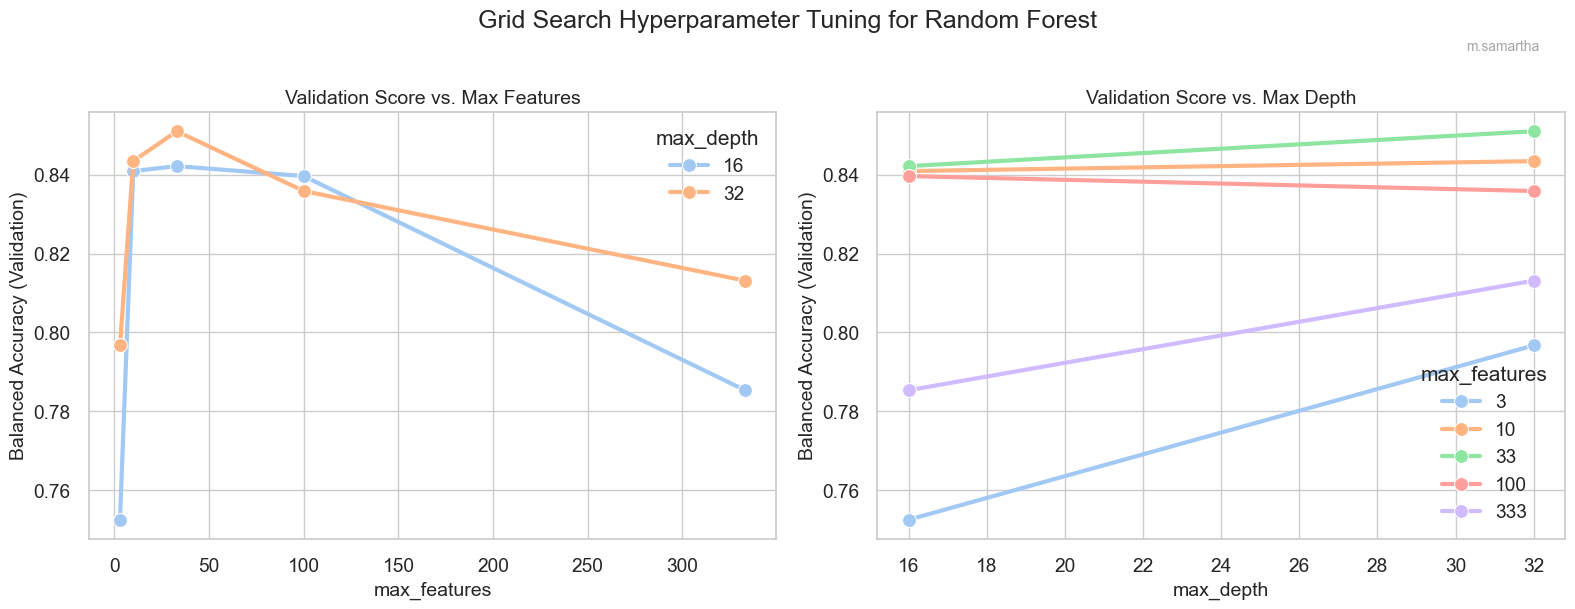

In [45]:
# --- Plotting the Grid Search Results ---
results_df = pd.DataFrame(grid_search.cv_results_)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Grid Search Hyperparameter Tuning for Random Forest', fontsize=18, y=1.02)

# Plot 1: Validation Score vs. Max Depth
sns.lineplot(
    data=results_df,
    x='param_max_features',
    y='mean_test_score',
    hue='param_max_depth',
    marker='o',
    markersize =10,
    palette='pastel',
    ax=axes[0],
    linewidth=3
)
axes[0].set_title('Validation Score vs. Max Features', fontsize=14)
axes[0].set_xlabel('max_features', fontsize=14)
axes[0].set_ylabel('Balanced Accuracy (Validation)', fontsize=14)
axes[0].legend(title='max_depth')
axes[0].grid(True)

# Plot 2: Validation Score vs. Min Samples Leaf
sns.lineplot(
    data=results_df,
    x='param_max_depth',
    y='mean_test_score',
    hue='param_max_features',
    marker='o',
    markersize =10,
    palette='pastel',
    ax=axes[1],
    linewidth=3
)
axes[1].set_title('Validation Score vs. Max Depth', fontsize=14)
axes[1].set_xlabel('max_depth', fontsize=14)
axes[1].set_ylabel('Balanced Accuracy (Validation)', fontsize=14)
axes[1].legend(title='max_features')
axes[1].grid(True)

plt.tight_layout()
add_username_fig(fig=fig)
plt.show()

### Build the best random forest using the best hyperparameters found in 2B 


In [21]:
print("\n--- Initializing Final RF Model with Best Parameters ---")
print(f"\nUsing parameters: {grid_search.best_params_}")

# --- Initialize the Final Model ---
final_rf_model = sklearn.ensemble.RandomForestClassifier(**grid_search.best_params_)

# --- Fit the Model *Only* on the Training Set ---
print("\nFitting the final model on the training set...")

final_rf_model.fit(x_train_NF, y_train_N)

print("\n--- Model training complete! ---")
print("The object 'final_rf_model' is now your trained classifier.")


--- Initializing Final RF Model with Best Parameters ---

Using parameters: {'max_depth': 32, 'max_features': 33, 'min_samples_leaf': 1, 'n_estimators': 100, 'random_state': 101}

Fitting the final model on the training set...

--- Model training complete! ---
The object 'final_rf_model' is now your trained classifier.


### Evaluate the best random forest model

In [33]:
# --- Evaluate the Best Random Forest Model ---
print("\n--- Evaluating Best Random Forest Model Performance ---")

# Make predictions
print("Making predictions on train, valid, and test sets...")
y_train_pred = final_rf_model.predict(x_train_NF)
y_valid_pred = final_rf_model.predict(x_valid_VF)
y_test_pred = final_rf_model.predict(x_test_TF)

# Calculate Balanced Accuracy (BAcc)
train_bacc = balanced_accuracy_score(y_train_N, y_train_pred)
valid_bacc = balanced_accuracy_score(y_valid_V, y_valid_pred)
test_bacc = balanced_accuracy_score(y_test_T, y_test_pred)

print("\nBalanced Accuracy (BAcc) Scores:")
print(f"  Training Set:   {train_bacc:.3f}")
print(f"  Validation Set: {valid_bacc:.3f}")
print(f"  Test Set:       {test_bacc:.3f}")



--- Evaluating Best Random Forest Model Performance ---
Making predictions on train, valid, and test sets...

Balanced Accuracy (BAcc) Scores:
  Training Set:   0.964
  Validation Set: 0.851
  Test Set:       0.837


### Final analysis questions

**Q: What is the value of max_features of your best forest?**

The value of max_features in my best random forest model is 33.

**Q: What is the maximum possible value for max_features for this dataset? Why is it beneficial to tune this hyperparameter?**

The maximum possible value for max_features is the total number of features in the dataset, which, based on your vocab_list, is 7729. Tuning this hyperparameter is important because it controls the balance between bias and variance in the Random Forest. A large value (e.g., 7729) means each tree considers nearly all features, making trees highly correlated and reducing ensemble diversity, which increases variance. A small value (e.g., 3) forces trees to use very few features, lowering correlation but increasing bias since trees may miss important predictors. Finding the right balance helps create trees that are both strong and diverse, minimizing the overall prediction error.

**Q: When fitting random forests, what is the primary tradeoff controlled by the n_estimators hyperparameter? Can you overfit by setting it to be too large? Why or why not?**

The n_estimators hyperparameter controls the tradeoff between computational cost and model stability. Increasing the number of trees generally improves model performance and stability, as more trees lead to better averaging of predictions, reducing variance. However, this also increases training time and memory usage linearly. With too few trees, the model trains quickly but may yield noisy and unstable predictions, whereas too many trees provide diminishing returns in accuracy improvement.

You cannot overfit a Random Forest by setting n_estimators too large. Each tree is trained on a random bootstrap sample and subset of features, and the model combines their outputs by averaging (for regression) or voting (for classification). Adding more trees simply refines this average, stabilizing predictions rather than increasing model complexity. Beyond a certain number, additional trees only make the model more consistent, not more overfitted.

## 3.3 Final Model Comparison 

|**method**|**max depth**|**num trees**|**train BAcc**|**valid BAcc**|**test BAcc**|
|:-|:-:|:-:|:-:|:-:|:-:|
|simple Tree	| 1 | 1 | 0.646	|0.645	|0.646|
|best Tree	|1 | 1 | 0.861	|0.873	|0.729|
|simple RandomForest	|1 | 1 | 0.816	|0.822	|0.784|
|best RandomForest	|1 | 1 | 0.964	|0.851	|0.837|

### Final Conclusions
The best Random Forest model achieves the highest overall performance across all datasets, with a train BAcc of **0.964**, validation BAcc of 0.851, and test BAcc of 0.837. This indicates that it generalizes well while maintaining strong predictive power. In contrast, while the best single Tree also shows high training and validation accuracy (0.861 and 0.873 respectively), its test BAcc drops to 0.729, suggesting mild overfitting. The simple Tree performs consistently but poorly (around 0.645–0.646), showing underfitting. The simple Random Forest improves performance (test BAcc 0.784) even without tuning, demonstrating the benefit of ensembling.

Overall, the results confirm that Random Forests outperform single decision trees, and that hyperparameter tuning (in the “best Random Forest”) significantly enhances generalization. Thus, the best Random Forest offers the optimal balance between bias and variance and is the most reliable model among all tested.